In [43]:
# Importing required libraries
import pickle
import nltk
import pandas as pd

# preprocessing dependencies
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# model dependencies
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
from keras.metrics import Precision, Recall

# plot dependencies
import matplotlib.pyplot as plt
import wordcloud

# Loading Data 

In [44]:
# load dataset
reddit = pd.read_csv('Reddit_Data.csv')
reddit.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [45]:
# check distribution of values
reddit['category'].value_counts()

 1    15830
 0    13142
-1     8277
Name: category, dtype: int64

**Check and Remove NaN Values**

In [46]:
# check NaN values
reddit.isna().sum()

clean_comment    100
category           0
dtype: int64

In [47]:
# drop NaN values
df = reddit.dropna()
data_v1 = df.copy()

# Data Cleaning and Preprocessing 

In [48]:
# clean dataset
def cleaning(df, stop_words):
    df['clean_comment'] = df['clean_comment'].apply(lambda x:' '.join(x.lower() for x in x.split()))
    # Replacing the digits/numbers
    df['clean_comment'] = df['clean_comment'].str.replace('d', '')
    # Removing stop words
    df['clean_comment'] = df['clean_comment'].apply(lambda x:' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatization
    df['clean_comment'] = df['clean_comment'].apply(lambda x:' '.join([Word(x).lemmatize() for x in x.split()]))
    return df

stop_words = stopwords.words('english')
data_v1 = cleaning(data_v1, stop_words)
data_v1.head()

,clean_comment,category
0,family mormon never trie explain still stare p...,1
1,buhism much lot compatible christianity especi...,1
2,seriously say thing first get complex explain ...,-1
3,learne want teach ifferent focus goal wrapping...,0
4,benefit may want rea living buha living christ...,1


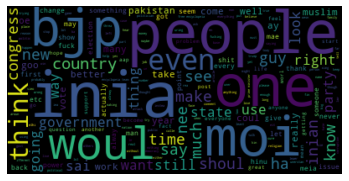

In [49]:
# check common words with wordcloud
common_words=''
for i in data_v1.clean_comment:  
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Encode Output Column**

In [50]:
# Encoded the target column
lb=LabelEncoder()
data_v1['category'] = lb.fit_transform(data_v1['category'])
data_v1.head()

,clean_comment,category
0,family mormon never trie explain still stare p...,2
1,buhism much lot compatible christianity especi...,2
2,seriously say thing first get complex explain ...,0
3,learne want teach ifferent focus goal wrapping...,1
4,benefit may want rea living buha living christ...,2


In [51]:
# tokenize input text
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_v1['clean_comment'].values)
X = tokenizer.texts_to_sequences(data_v1['clean_comment'].values)
X = pad_sequences(X)

In [52]:
# saving tokenizer
with open('tokenizer_LSTM.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Model Building

In [54]:
# create model architecture
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy', Precision(), Recall()])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 464, 120)          60000     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 464, 120)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 3)                 531       
                                                                 
Total params: 269,619
Trainable params: 269,619
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
# Splitting the data into training and testing
y = pd.get_dummies(data_v1['category'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [62]:
# run model 
batch_size=32
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test),
                    epochs = 5, batch_size = batch_size, 
                    verbose = 'auto')

Epoch 1/5
813/813 [==============================] - 1434s 2s/step - loss: 0.7367 - accuracy: 0.6900 - precision: 0.7464 - recall: 0.6017 - val_loss: 0.6503 - val_accuracy: 0.7425 - val_precision: 0.7758 - val_recall: 0.6984
Epoch 2/5
813/813 [==============================] - 1546s 2s/step - loss: 0.6388 - accuracy: 0.7478 - precision: 0.7767 - recall: 0.7091 - val_loss: 0.6443 - val_accuracy: 0.7474 - val_precision: 0.7760 - val_recall: 0.7101
Epoch 3/5
813/813 [==============================] - 1387s 2s/step - loss: 0.6279 - accuracy: 0.7528 - precision: 0.7778 - recall: 0.7136 - val_loss: 0.6410 - val_accuracy: 0.7492 - val_precision: 0.7837 - val_recall: 0.7046
Epoch 4/5
813/813 [==============================] - 1565s 2s/step - loss: 0.6190 - accuracy: 0.7557 - precision: 0.7844 - recall: 0.7179 - val_loss: 0.6393 - val_accuracy: 0.7468 - val_precision: 0.7733 - val_recall: 0.7186
Epoch 5/5
813/813 [==============================] - 1610s 2s/step - loss: 0.6132 - accuracy: 0.7569

# Model Evaluation 

In [63]:
# evaluate the model on testing dataset
model.evaluate(X_test,y_test)

349/349 [==============================] - 79s 226ms/step - loss: 0.6455 - accuracy: 0.7466 - precision: 0.7797 - recall: 0.7050


[0.6455134153366089,
 0.7466128468513489,
 0.7796963453292847,
 0.7049798369407654]

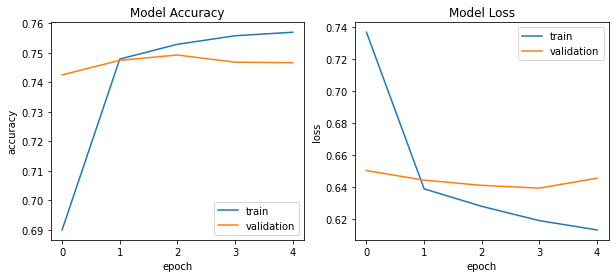

In [64]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

In [65]:
# save model
model.save('model_LSTM.h5')

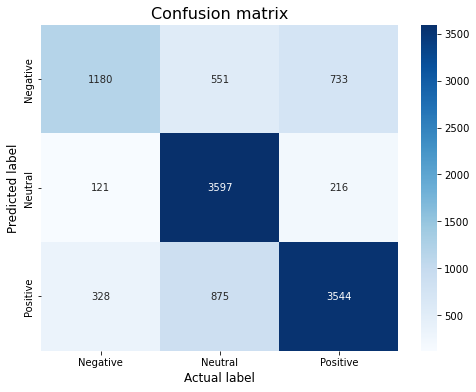

In [66]:
# check model's performance on testing data
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns 

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

# Model Testing

In [67]:
# load required libraries
from keras import backend as K
from tensorflow.keras.models import Model, load_model

In [68]:
# load trained model
model = load_model('model_LSTM.h5')

In [69]:
# load tokenizer
import pickle 

with open('tokenizer_LSTM.pkl','rb') as handle:
    tokenizer = pickle.load(handle)

In [81]:
# input data
text = '''seriously don say thing first all they won get its too complex explain normal people anyway and they are dogmatic then doesn matter what you say see mechante post and for any reason you decide later life move from buddhism and that doesn suit you identity though you still get keep all the wisdom then your family will treat you like you went through weird hippy phase for while there didncha and you never hear the end pro tip don put one these your wall jpg '''

In [82]:
# clean text for model 
def text_cleaning(text, stop_words):
    text = text.lower()
    # Replacing the digits/numbers
    text = text.replace('d', '')
    # remove stopwords
    words = [w for w in text if w not in stopwords.words("english")]
    # apply stemming
    words = [Word(w).lemmatize() for w in words]
    # merge words 
    words = ' '.join(words)
    return text

# apply text cleaning
stop_words = stopwords.words('english')
text = text_cleaning(text, stop_words)

In [83]:
# tokenize and pad input data
sequences = tokenizer.texts_to_sequences([text])
t_text = pad_sequences(sequences, maxlen =  464)

In [84]:
# make predictions
# Negative, Neutral, Positive
prediction = model.predict(t_text)

prediction_class = prediction.argmax(axis=-1)[0]
if prediction_class == 0:
    print('Thread has negative sentiment')
if prediction_class == 1:
    print('Thread has neutral sentiment')
if prediction_class == 2:
    print('Thread has positive sentiment')

Thread has positive sentiment
